# Corso di Quantum Computing - Giorno 4

In questo laboratorio vedremo due possibili implementazioni della Quantum Phase Estimation per poi passare all'implementazione dell'algoritmo di Shor. Nel corso di questo notebook faremo alcune simulazioni su "hardware" rumoroso.

Corso per Epigenesys s.r.l. <br>
Docenti: Sara Galatro e Lorenzo Gasparini <br>
Supervisore: Prof. Marco Pedicini

## Per iniziare

In [57]:
#!pip install qiskit
#!pip install qiskit_aer

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.visualization import array_to_latex
from qiskit.quantum_info import Statevector
from qiskit.quantum_info.operators import Operator
from qiskit.visualization import plot_histogram
from qiskit.primitives import Sampler
from qiskit.circuit.library import QFT
from qiskit.circuit import Gate

import numpy as np
from numpy import pi, sin, cos
from math import gcd
import matplotlib.pyplot as plt

***
## Decomposizione Spettrale
***

Prima di procedere con la QPE, che ne dite di verificare che la decomposizione spettrale vista per l'Hadamard gate $\mathbf{H}$ sia corretta?

Vi ricordiamo che potete definire uno stato quantistico $|\psi\rangle$ tramite la classe `Statevector` di Qiskit e che trasformare l'oggetto ottenuto in un `Operator` genera l'operatore proiezione di quel vettore, ossia $|\psi\rangle\langle\psi|$.

**Ex.1 - Verificate che la decomposizione spettrale vista nelle slide sia corretta**

In [2]:
# soluzione 
psi1 = Statevector([np.cos(pi / 8), np.sin(pi / 8)])
psi2 = Statevector([np.cos(5 * pi / 8), np.sin(5 * pi / 8)])

H = Operator(psi1) - Operator(psi2)

display(array_to_latex(H))

<IPython.core.display.Latex object>

***
## Quantum Phase Estimation
***

Esploreremo ora la procedura per la Phase Estimation, un algoritmo quantistico per un problema completamente quantistico, partendo da un approccio a bassa precisione per poi generalizzarlo tramite Quantum Fourier Transform, concludendo con l'analisi delle sue performance.

### Approssimazione a bassa precisione

La strategia più semplice si basa sul fenomeno del **phase kick-back**, che vedremo essere la vesione a un qubit del procedimento generale.

Supponiamo dunque di avere in input un circuito che rappresenti una qualche operazione unitaria $\mathbf{U}$ e creiamo il circuito **Controlled-U** aggiungendo un qubit di controllo e sostituendo tutti i gate che formano $\mathbf{U}$ con gate controllati dallo stesso effetto: in questo modo, il nostro nuovo qubit controllerà effetivamente tutti i gate nel circuito di $\mathbf{U}$.

<center>

<img src="./images/CU.png" alt="CU" width="350"/>

</center>

Consideriamo ora il seguente circuito

<center>

<img src="./images/QPE_analysis_1.png" alt="QPE1" width="800"/>

</center>

e analizziamolo passo passo, così da vedere come l'autovalore corrispondente all'autovettore $|\psi\rangle$ influenzi le probabilità di output:
0. Lo stato iniziale del circuito è
$$
    |\pi_0\rangle = |\psi\rangle|0\rangle
$$

1. Il primo gate Hadamard trasforma $|\pi_0\rangle$ in 
$$
    |\pi_1\rangle = |\psi\rangle|+\rangle = \frac{1}{\sqrt{2}}|\psi\rangle|0\rangle + \frac{1}{\sqrt{2}}|\psi\rangle|1\rangle
$$

2. Ora applichiamo la nostra operazione controlled-$\mathbf{U}$, ottenendo lo stato
$$
    \begin{align*}
    |\pi_2\rangle &= \frac{1}{\sqrt{2}}|\psi\rangle|0\rangle + \frac{1}{\sqrt{2}} \left(\mathbf{U}|\psi\rangle\right)|1\rangle \overset{\lambda = e^{2\pi i\theta}}{=}\\
                  &= \frac{1}{\sqrt{2}}|\psi\rangle|0\rangle + \frac{e^{2\pi i \theta}}{\sqrt{2}} |\psi\rangle|1\rangle = \\
                  &= |\psi\rangle \otimes \left( \frac{1}{\sqrt{2}}|0\rangle + \frac{e^{2\pi i \theta}}{\sqrt{2}} |1\rangle \right)
    \end{align*}
$$

3. Infine, applichiamo un secondo Hadamard gate:
$$
    |\pi_3\rangle = |\psi\rangle \otimes \left( \frac{1 + e^{2\pi i \theta} }{2}|0\rangle + \frac{1 - e^{2\pi i \theta}}{2} |1\rangle \right)
$$

La distribuzione di probabilità finale sarà dunque
$$
    \mathbb{P}(outcome = 0) = \left\vert \frac{1 + e^{2\pi i \theta} }{2} \right\vert^2 = \cos^2(\pi\theta) \qquad 
    \mathbb{P}(outcome = 1) = \left\vert \frac{1 - e^{2\pi i \theta} }{2} \right\vert^2 = \sin^2(\pi\theta)
$$

Vediamo l'andamento di queste probabilità:

Primi 10 valori per l'angolo:
  [0.     0.0096 0.0192 0.0288 0.0385 0.0481 0.0577 0.0673 0.0769 0.0865]
Primi 10 valori per il seno:
  [0.     0.0009 0.0036 0.0082 0.0145 0.0226 0.0325 0.0441 0.0573 0.0721]
Primi 10 valori per il coseno:
  [1.     0.9991 0.9964 0.9918 0.9855 0.9774 0.9675 0.9559 0.9427 0.9279]

Plot:


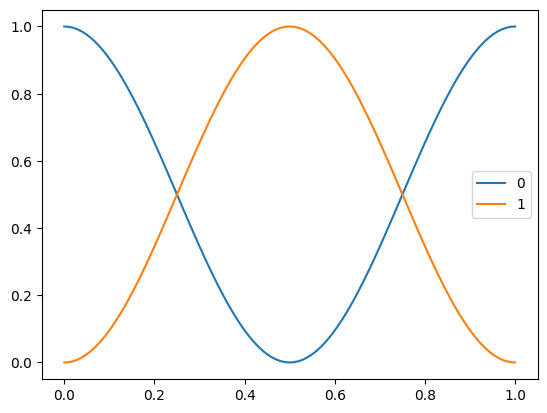

In [3]:
theta_list = np.linspace(0.0, 1.0, num = 105)
num_shots = len(theta_list)

sin_list = np.zeros(num_shots)
cos_list = np.zeros(num_shots)

for t in range(num_shots):

    sin_list[t] = np.sin(pi*theta_list[t])**2
    cos_list[t] = np.cos(pi*theta_list[t])**2

# the print is truncated to 4 decimal for visualization purposes
print("Primi 10 valori per l'angolo:\n ", theta_list[:10].round(4))
print("Primi 10 valori per il seno:\n ", sin_list[:10].round(4))
print("Primi 10 valori per il coseno:\n ", cos_list[:10].round(4))

# plot
print("\nPlot:")
plt.plot(theta_list, cos_list, label = "0")
plt.plot(theta_list, sin_list, label = "1")
plt.legend()
plt.show()

Ma che tipo di informazioni possiamo ricavare da questo plot?

Intuitivamente, possiamo pensare all'output della nostra misurazione come a una stima per $\theta$ fino a *un bit di accuratezza*. In altre parole, se scrivessimo $\theta$ in notazione binaria, i.e. come somma di frazioni di potenze di due in questo modo
$$
    \theta = 0.\theta_1\theta_2\theta_3...\theta_t = \frac{\theta_1}{2^1} + \frac{\theta_2}{2^2} + \frac{\theta_3}{2^3} + ... + \frac{\theta_t}{2^t} 
$$
e lo arrotondassimo al primo bit dopo il punto binario, avremmo un numero di questo tipo
$$
    0.a = 
    \begin{cases}
        0 & a=0\\
        1/2 & a=1
    \end{cases}
$$
In questo modo, il risultato misurato alla fine del nostro circuito è la stima per $\theta$ che volevamo.

Viene ora spontaneo chiedersi che ruolo abbiano i gate Hadamard in questo circuito:
* il primo Hadamard gate pone il qubit di controllo in una sovrapposizione uniforme di $|0\rangle$ e $|1\rangle$, così che il phase kickback avvenga solo per lo stato $|1\rangle$, creando in questo modo una differenza nelle **fasi relative** che influenzerà le distribuzioni di probabilità;
* il secondo Hadamard gate ci permette di scoprire qualcosa sul numero $\theta$ tramite **interferenza**. Prima di applicare Hadamard il nostro qubit di controllo è nello stato $\frac{1}{\sqrt{2}} |0\rangle + \frac{e^{2\pi i\theta}}{\sqrt{2}} |1\rangle $, che darebbe in output $0$ o $1$ con uguale probabilità.

Per fissare le idee, costruiamo un circuito specifico e vediamone il funzionamento. Per semplicità, fissiamo che il nostro gate $\mathbf{CU}$ sia una rotazione controllata, così che l'autovettore sia lo stato $|1\rangle$:

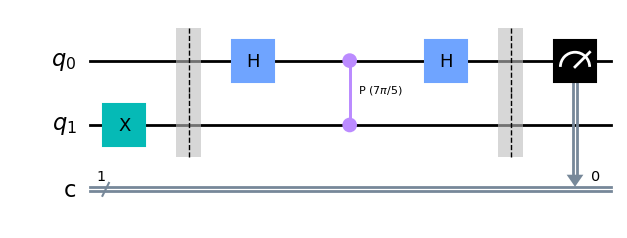

In [4]:
theta = 0.7  # Can be changed to any value between 0 and 1

qc = QuantumCircuit(2, 1)

# Prepare eigenvector, which is the |1> state
qc.x(1)
qc.barrier()

# Implement the estimation procedure
qc.h(0)
qc.cp(2 * pi * theta, 0, 1)
qc.h(0)
qc.barrier()

# Perform the final measurement
qc.measure(0, 0)

# Draw the circuit
qc.draw('mpl')

Eseguiamo il circuito usando la primitiva `sampler`:

In [5]:
display(Sampler().run(qc).result().quasi_dists[0])

{0: 0.3454915028125262, 1: 0.6545084971874736}

E calcoliamo i risultati corretti (dalla teoria) così da confrontarli con quelli sperimentali:

In [6]:
display({  
    # Calculate predicted results 
    0: cos(pi * theta) ** 2,
    1: sin(pi * theta) ** 2
})

{0: 0.34549150281252616, 1: 0.6545084971874737}

### Raddoppiamo la fase

Abbiamo appena visto come approssimare la fase a un bit di precisione, accuratezza che in molte situazioni sarà sufficiente ma non in tutte. Dunque come possiamo ottenere più informazioni su $\theta$?

Una prima idea potrebbe essere di applicare due volte la nostra operazione controllata $\mathbf{CU}$, come si vede nella seguente immagine:

<center>

<img src="./images/double_CU.png" alt="DCU" width="800"/>

</center>

Avere due copie di $\mathbf{CU}$ in sequenza in questo modo equivale a un solo gate $\mathbf{Controlled-U^2}$ e dunque, se $|\psi\rangle$ è un autovettore di $\mathbf{U}$ con autovalore $\lambda = e^{2\pi i\theta}$, avremo che $|\psi\rangle$ è anche autovettore di $\mathbf{U}$ ma con autovalore pari a $\lambda^2 = e^{2\pi i(2\theta)}$. 

Quindi, se eseguiamo questo circuito, stiamo effettuando esattamente la stessa computazione di prima, solo con $2\theta$. Vediamo il plot delle probabilità di output al variare di $\theta\in[0,1]$.

Primi 10 valori per l'angolo:
  [0.     0.0096 0.0192 0.0288 0.0385 0.0481 0.0577 0.0673 0.0769 0.0865]
Primi 10 valori per il seno:
  [0.     0.0036 0.0145 0.0325 0.0573 0.0885 0.1257 0.1684 0.216  0.2676]
Primi 10 valori per il coseno:
  [1.     0.9964 0.9855 0.9675 0.9427 0.9115 0.8743 0.8316 0.784  0.7324]

Plot:


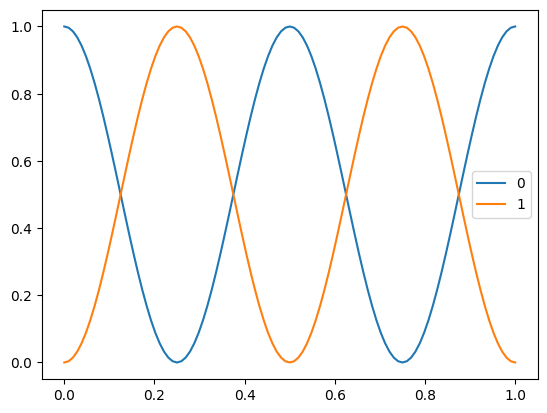

In [7]:
theta_list = np.linspace(0.0, 1.0, num = 105)
num_shots = len(theta_list)

sin_list = np.zeros(num_shots)
cos_list = np.zeros(num_shots)

for t in range(num_shots):

    sin_list[t] = np.sin(2*pi*theta_list[t])**2
    cos_list[t] = np.cos(2*pi*theta_list[t])**2

# the print is truncated to 4 decimal for visualization purposes
print("Primi 10 valori per l'angolo:\n ", theta_list[:10].round(4))
print("Primi 10 valori per il seno:\n ", sin_list[:10].round(4))
print("Primi 10 valori per il coseno:\n ", cos_list[:10].round(4))

# plot
print("\nPlot:")
plt.plot(theta_list, cos_list, label = "0")
plt.plot(theta_list, sin_list, label = "1")
plt.legend()
plt.show()

Ma in che modo questa procedura ci permette di scoprire altre informazioni su $\theta$? Riprendiamo la forma binaria di $\theta$
$$
    \theta = 0.a_1 a_2 a_3 \cdots
$$
Raddoppiare $\theta$ causa uno spostamento del punto binario di una posizione verso destra, ossia
$$
    2\theta = a_1.a_2 a_3 \cdots
$$

Dato che ci stiamo muovendo sempre intorno a un cerchio (i.e. $\theta = 0 \equiv 1$), possiamo vedere che $a_1$ non influenza più le nostre misurazioni e dunque la nostra stima sarebbe effettivamente per $a_2$, ossia il nostro secondo bit.

### Two-Qubits Phase Estimation

Invece di onsiderare separatamente i due procedimenti descritti, proviamo a combinarli come segue

<center>

<img src="./images/two_PE_a.png" alt="DCU" width="800"/>

</center>

e analizziamone l'effetto:
1. Dopo l'applicazione di Hadamard a entrambi i qubit abbiamo uno stato
$$
    |\pi_1\rangle = |\psi\rangle \otimes \frac{1}{2} \sum_{a_0=0}^1 \sum_{a_1=0}^1 |a_1a_0\rangle
$$

2. Quando applichiamo la prima $\mathbf{CU}$, l'autovalore $\lambda = e^{2\pi i \theta}$ viene inserito nella fase se il qubit più in alto (i.e. $a_0$) è nello stato $|1\rangle$
$$
    |\pi_2\rangle = |\psi\rangle \otimes \frac{1}{2} \sum_{a_0=0}^1 \sum_{a_1=0}^1 e^{2\pi i a_0 \theta}|a_1a_0\rangle
$$

3. La seconda $\mathbf{CU}$ ha un effetto analogo, solo che il qubit di controllo è ora quello relativo ad $a_1$ e $\theta$ viene sostituito da $2\theta$
$$
    |\pi_3\rangle = |\psi\rangle \otimes \frac{1}{2} \sum_{a_0=0}^1 \sum_{a_1=0}^1 e^{2\pi i (2a_1 + a_0) \theta}|a_1a_0\rangle
$$

Osserviamo che, se convertiamo le stringhe dal binario agli interi, otteniamo che $a_1a_0 \equiv x = 2a_1 + a_0 \in\{0,1,2,3\}$ e quindi possiamo riscrivere quest'ultimo stato come
$$
    |\pi_3\rangle = |\psi\rangle \otimes \frac{1}{2} \sum_{x=0}^3 e^{2\pi i x \theta}|x\rangle
$$

A questo punto consideriamo un caso specifico, in cui ci viene promesso che $\theta = \frac{y}{4}$ per qualche intero $y\in\{0,1,2,3\}$, ossia $\theta \in \{ 0, \frac{1}{4},\frac{1}{2},\frac{3}{4}\}$, così da poter esprimere tale valore in notazione binaria esatta usando due bit, ossia $.00, .01,.10$ e $.11$.

Definiamo uno stato a due qubit per ogni possibile valore $y\in\{0,1,2,3\}$:
$$
    |\phi_y\rangle = \frac{1}{2} \sum_{x=0}^3 e^{2\pi i x \frac{y}{4}} |x\rangle = \frac{1}{2} \sum_{x=0}^3 e^{2\pi i \frac{xy}{4}} |x\rangle
$$
Semplificando gli esponenziali otteniamo i seguenti stati
$$
    \begin{align*}
        |\phi_0\rangle &= \frac{1}{2} |0\rangle + \frac{1}{2} |1\rangle + \frac{1}{2} |2\rangle + \frac{1}{2} |3\rangle \\
        |\phi_1\rangle &= \frac{1}{2} |0\rangle + \frac{i}{2} |1\rangle - \frac{1}{2} |2\rangle - \frac{i}{2} |3\rangle \\
        |\phi_2\rangle &= \frac{1}{2} |0\rangle - \frac{1}{2} |1\rangle + \frac{1}{2} |2\rangle - \frac{1}{2} |3\rangle \\
        |\phi_3\rangle &= \frac{1}{2} |0\rangle - \frac{i}{2} |1\rangle - \frac{1}{2} |2\rangle + \frac{i}{2} |3\rangle \\
    \end{align*}
$$
che possiamo osservare essere una base ortonormale.

Per discriminarli perfettamente con un circuito quantistico, vogliamo definire un operatore unitario $\mathbf{V}$ che trasforma i vettori della base standard nei quattro vettori appena visti, ossia
$$
    \begin{align*}
        \mathbf{V}|00\rangle &= |\phi_0\rangle \\
        \mathbf{V}|01\rangle &= |\phi_1\rangle \\
        \mathbf{V}|10\rangle &= |\phi_2\rangle \\
        \mathbf{V}|11\rangle &= |\phi_3\rangle \\
    \end{align*}
$$
e per ottenerne una definizione esplicita ci basta prendere la matrice cha abbia per colonne le ampiezze degli stati $|\phi_0\rangle, \ldots, |\phi_3\rangle $:
$$
    \mathbf{V} = \frac{1}{2}
    \begin{bmatrix}
        1 & 1 & 1 & 1\\
        1 & i & -1 & -i\\
        1 & -1 & 1 & -1\\
        1 & -i & -1 & i\\
    \end{bmatrix}
    \equiv \mathbf{QFT_4}
$$

Invertendo tale operazione, siamo in grado di riportare il nostro stato a uno della base standard, così da poter effettuare le misurazioni, e ricavare il valore di $y$ che descrive $\theta$, dato che lo stato finale prima del collasso sarà descritto come $|\psi\rangle |y\rangle$. 

Il circuito completo è il seguente

<center>

<img src="./images/2_PE_QFT.png" alt="2QFT" width="1000"/>

</center>

Vediamo le distribuzioni di probabilità:

<center>

<img src="./images/probs.png" alt="probs" width="800"/>

</center>

Nonostante abbiamo costruito questo circuito nel caso specifico di $\theta = y/4$, possiamo in realtà eseguirlo per qualsiasi scelta di $\mathbf{U}$ e di $|\psi\rangle$, ossia per qualsiasi valore di $\theta$.

Vediamo dunque una possibili implementazione in Qiskit, prendendo $\mathbf{U}$ sempre come un operatore di fase:

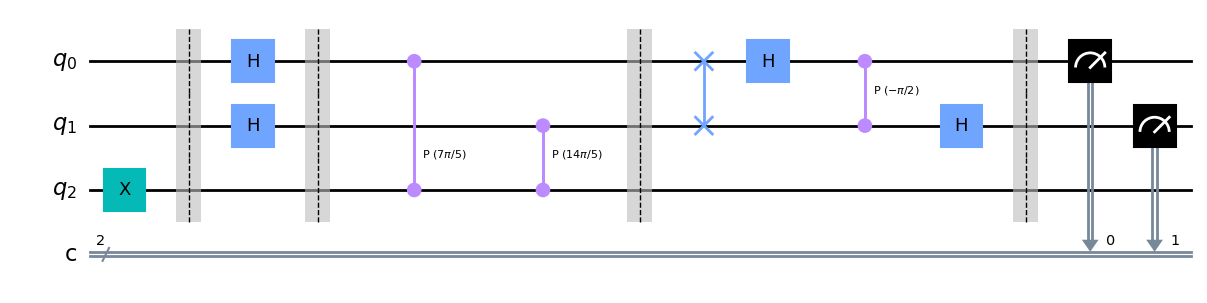

In [8]:
theta = 0.7
qc = QuantumCircuit(3, 2)

# Prepare the eigenvector
qc.x(2)
qc.barrier()

# The initial Hadamard gates
qc.h(0)
qc.h(1)
qc.barrier()

# The controlled unitary gates
qc.cp(2 * pi * theta, 0, 2)
qc.cp(2 * pi * (2 * theta), 1, 2)
qc.barrier()

# An implementation of the inverse of the two-qubit QFT
qc.swap(0, 1)
qc.h(0)
qc.cp(-pi / 2, 0, 1)
qc.h(1)
qc.barrier()

# And finally the measurements
qc.measure([0, 1], [0, 1])
qc.draw('mpl')

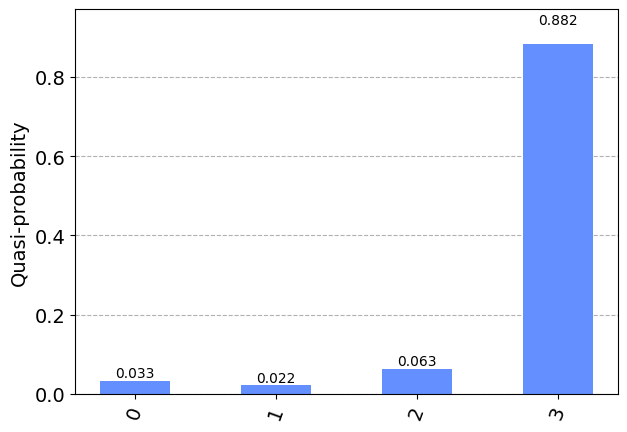

In [9]:
result = Sampler().run(qc).result()
display(plot_histogram(result.quasi_dists))

### Generalizzazione a $n$ qubit

Per generalizzare la Quantum Phase Estimation ci basterà dunque aggiungere ulteriori qubit di controllo con le relative applicazioni di $\mathbf{U}$ e aumentare la dimensione della $\mathbf{QFT}$, fino ad arrivare alla precisione desiderata. Circuitalmente, possiamo immaginare tale procedura come segue:

<center>

<img src="./images/complete_pe.png" alt="complete" width="1000"/>

</center>

In generale, aggiungere qubit di controllo in questo modo comporta un incremento significativo nella taglia del circuito: infatti, se abbiamo $m$ qubit di controllo, serviranno $2^m -1$ copie di $\mathbf{U}$ per portare a termine la computazione. Dunque aumentare $m$ implica un **aumento del costo computazionale**, anche se significa anche migliorare di molto l'**accuratezza** della nostra stima.

Analizziamo dunque il circuito appena presentato: subito prima della $\mathbf{QFT}$ ha la seguente forma
$$
    \frac{1}{\sqrt{2^m}} \sum_{x=0}^{2^m - 1} (\mathbf{U}^x |\psi\rangle)|x\rangle = \psi \otimes \frac{1}{\sqrt{2^m}} \sum_{x=0}^{2^m - 1} e^{2\pi i x\theta} |x\rangle 
$$

Come nei casi precedenti, poniamoci nel caso in cui $\theta = \frac{y}{2^m}$, con $y\in\{0,\ldots, 2^m - 1\}$, e riscriviamo lo stato come
$$
    \psi \otimes \frac{1}{\sqrt{2^m}} \sum_{x=0}^{2^m - 1} e^{2\pi i \frac{xy}{2^m}} |x\rangle  = 
    |\psi\rangle \otimes \frac{1}{\sqrt{2^m}} \sum_{x=0}^{2^m - 1} \omega_{2^m}^{xy} |x\rangle =
    |\psi\rangle \otimes \mathbf{QFT}_{2^m}|y\rangle
$$
Dunque, applicare la $\mathbf{QFT}$ inversa porterà il nostro sistema nello stato $|\psi\rangle|y\rangle$, dove $y$ è codificata in binario, proprio come ci aspettavamo.

Per valori generici di $\theta$ il risultato delle misurazioni non sarà certo, ma possiamo provare alcuni limiti sulle probabilità dei diversi risultati. Supponiamo dunque di avere un $\theta$ arbitrario tale che $0\leq \theta < 1$.

Dopo l'applicazione della $\mathbf{QFT}$ inversa, il nostro sistema si trova nello stato
$$
    |\psi\rangle \otimes \frac{1}{2^m}\sum_{y=0}^{2^m - 1} \sum_{x=0}^{2^m - 1} e^{2\pi i x (\theta - y/2^m)} |y\rangle
$$
e dunque le probabilità di misurazione dei primi $m$ qubit sarà
$$
    \mathbb{P}(outcome = y) = \left\vert \frac{1}{2^m} \sum_{x=0}^{2^m - 1} e^{2\pi i x (\theta - y/2^m)} \right\vert
$$

Possiamo meglio interpretare queste probabilità sfruttando il fatto che siano delle **somme geometriche**, le cui somme parziali sono tali che
$$
    1 + \alpha + \alpha^2 + \cdots + \alpha^{N-1} = 
    \begin{cases}
        \frac{\alpha^N -1}{\alpha - 1} & \alpha\neq 1\\
        N                              & \alpha =  1\\
    \end{cases}
$$
e dunque nel nostro caso
$$
    \sum_{x=0}^{2^m - 1} e^{2\pi i x (\theta - y/2^m)} = \frac{e^{2\pi(2^m\theta - y)} - 1}{e^{2\pi(\theta - y/2^m)} - 1} \cdot \mathbb{1}_{\theta \neq y/2^m} + 2^m \cdot \mathbb{1}_{\theta = y/2^m}
$$
Le probabilità dunque sono
$$
    \mathbb{P}(outcome = y) = 1 \cdot \mathbb{1}_{\theta = y/2^m} + \frac{1}{2^{2m}} \left\vert \frac{e^{2\pi(2^m\theta - y)} - 1}{e^{2\pi(\theta - y/2^m)} - 1} \right\vert^2 \cdot \mathbb{1}_{\theta \neq y/2^m}
$$

Per cercare di capire come siano limitate queste probabilità portiamoci in un setting geometrico, analizzando in particolare come si relazionano un arco e la relativa corda su una circonferenza.

<center>

<img src="./images/arc_vs_chord.png" alt="arc" width="700"/>

</center>

Supponiamo che $\delta\in\left[ -\frac{1}{2}, \frac{1}{2} \right]$ e iniziamo osservando che la corda non potrà mai essere più lunga dell'arco, ossia
$$
    \vert e^{2\pi i \delta} - 1 \vert \leq 2\pi\vert\delta\vert
$$
Nell'altro verso, possiamo osservare che il rapporto tra la lunghezza dell'arco e la lunghezza della corda è massimo quando $\delta = \pm\frac{1}{2}$, caso in cui il rapporto è la metà della circonferenza diviso il diametro (che é $\pi/2$). Possiamo quindi scrivere
$$
    4\vert\delta \vert \leq \vert e^{2\pi i \delta} - 1 \vert
$$


Analizzando queste due relazioni otteniamo due fatti interessanti: supponiamo innanzitutto che $\theta$ sia un numero reale e che $y\in\{0,\ldots,2^m - 1\}$ soddisfi
$$
    \left\vert \theta - \frac{y}{2^m}\right\vert \leq 2^{-(m+1)}
$$  
Ciò significa che $\frac{y}{2^m}$ è la **miglior approssimazione a $m$ bit** di $\theta$, o una tra le due migliori approssimazioni nel caso (peggiore) in cui $\theta$ sia esattamente a metà tra $\frac{y\pm 1}{2^m}$ e $\frac{y}{2^m}$. Sotto questa ipotesi, otteniamo che $2^m\theta - y \leq 1/2$ ottenendo che
$$
    \vert e^{2\pi i (2^m\theta - y)} - 1 \vert \geq 4 \vert 2^m \theta - y\vert = 4\cdot2^m\cdot \left\vert\theta - \frac{y}{2^m}\right\vert
$$
Inoltre
$$
    \vert e^{2\pi i (\theta - y/2^m)} - 1 \vert \leq 2\pi \left\vert\theta - \frac{y}{2^m}\right\vert
$$
e dunque otteniamo che
$$
    \mathbb{P}(outcome = y) \geq \frac{1}{2^{2m}}\frac{16\cdot 2^{2m}}{4\pi^2} = \frac{4}{\pi^2} \approx 0.405
$$


Supponiamo ora che $y\in\{0,\ldots,2^m-1\}$ soddisfi
$$
    \frac{1}{2^m} \leq \left\vert \theta - \frac{y}{2^m} \right\vert \leq \frac{1}{2}
$$
Iniziamo osservando che, dato che siamo sulla circonferenza di raggio $1$, si ha che
$$
    \vert e^{2\pi (2^m\theta - y)} - 1 \vert \leq 2
$$
Inoltre, dalla seconda osservazione sugli archi e sulle corde, otteniamo che
$$
    \left\vert e^{2\pi(\theta - y/2^m)} -1 \right\vert \geq 4 \left\vert \theta - \frac{y}{2^m}\right\vert \geq 4\cdot 2^{-m}
$$
Unendo queste relazioni otteniamo
$$
    \mathbb{P}(outcome = y) \leq \frac{1}{2^{2m}} \frac{4}{16\cdot2^{-2m}} = \frac{1}{4}
$$

Abbiamo quindi dimostrato che le approssimazioni migliori si misurano con probabilità almeno pari al $40\%$, mentre le approssimazioni imprecise più di $2^{-m}$ sono poco probabili, occorrendo al massimo con probabilità pari a $25\%$.

Se volessimo aumentare ancora la nostra sicurezza nel risultato, potremmo ripetere la procedura di stima della fase diverse volte, così da ottenere una prova statistica del nostro risultato. Osserviamo che lo stato $|\psi\rangle$ del sottosistema inferiore del nostro circuito è invariato a fine procedura, il che ci permette di continuare a utilizzarlo per eseguire la QPE quante volte desideriamo.

**Ex.2 - Costruire il circuito per la QPE generalizzata**

Supponete ancora che $\mathbf{CU}$ sia un'operazione di fase controllata $\mathbf{CP}(\alpha)$.

Vi riportiamo anche la documentazione necessaria per implementare la QFT: [QFT documentation](https://qiskit.org/documentation/stubs/qiskit.circuit.library.QFT.html).

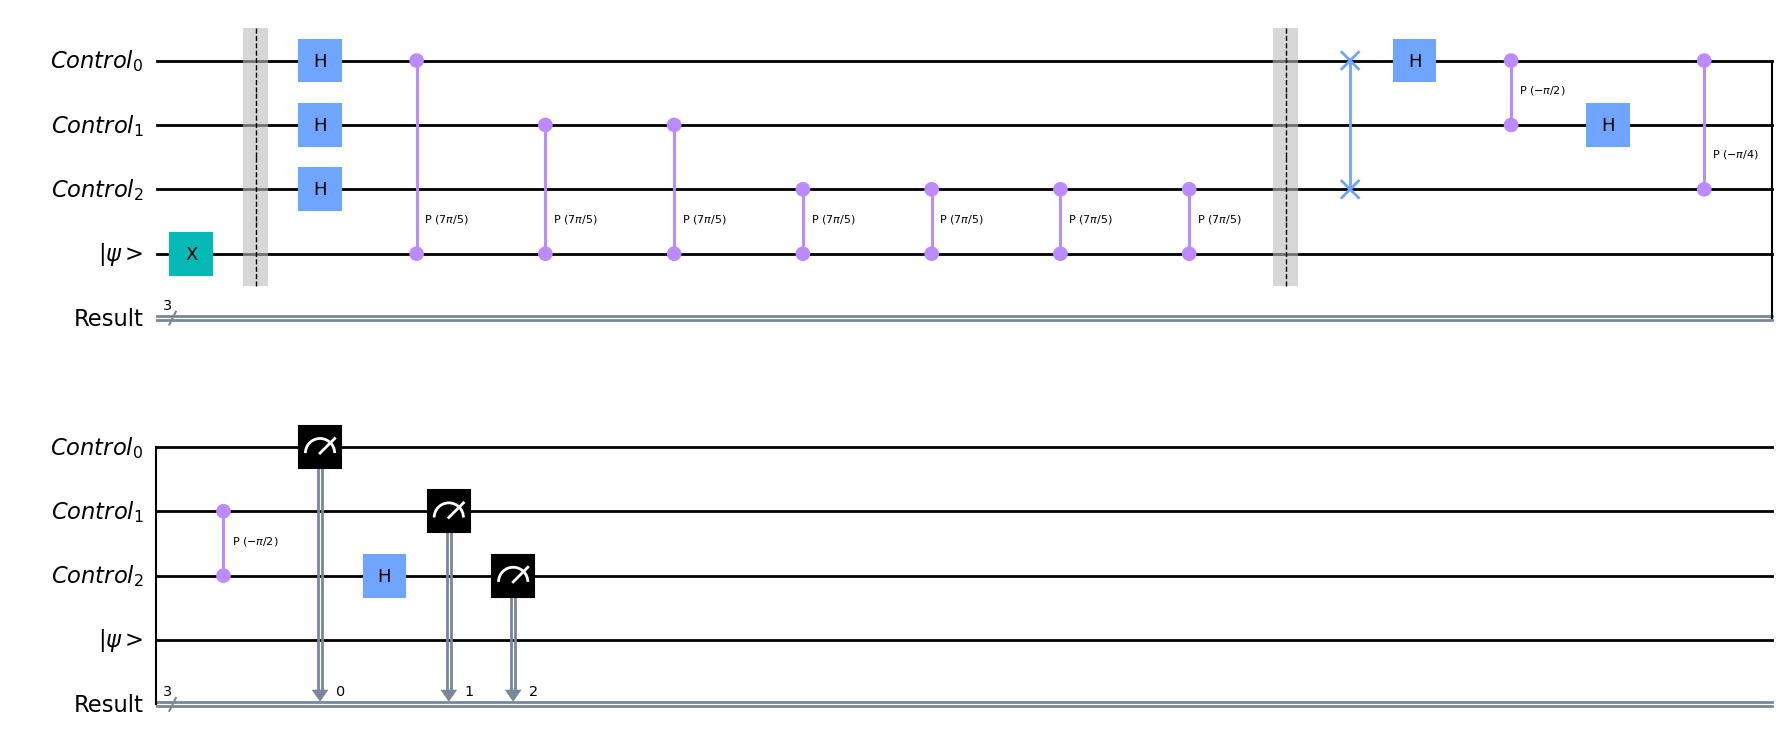

In [10]:
theta = 0.7
m = 3  # Number of control qubits

# circuit
control_register = QuantumRegister(m, name="Control")
target_register = QuantumRegister(1, name="|ψ>")          # add your code here
output_register = ClassicalRegister(m, name="Result")
qc = QuantumCircuit(control_register, target_register, output_register)

# prepare the eigenvector |ψ> as |1>
# add your code here
qc.x(target_register)

# barrier
qc.barrier()

# perform phase estimation
# add your code here
for qubit in range(control_register.size):
    qc.h(qubit)
    for _ in range(2**qubit):
        qc.cp(2 * pi * theta, qubit, target_register)

# barrier
qc.barrier()

# do inverse quantum Fourier transform
qc.compose(
    QFT(m, inverse=True).decompose(),       # add your code here
    inplace=True
)

# measure everything
# add your code here
qc.measure(range(m), range(m))

# draw circuit
qc.draw('mpl')

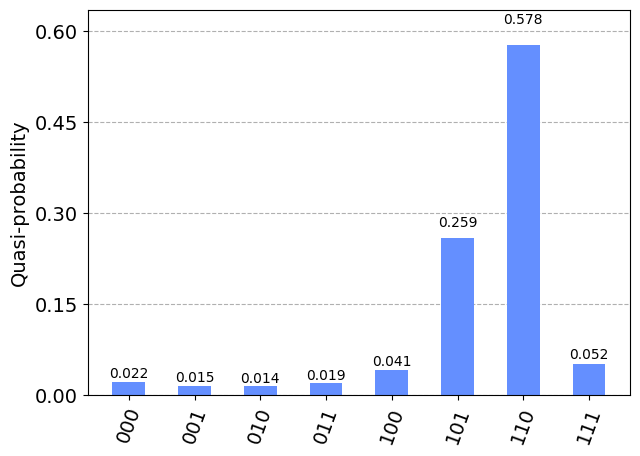

In [11]:
# run
result = Sampler().run(qc).result()
display(plot_histogram(result.quasi_dists[0].binary_probabilities()))

In [12]:
most_probable = max(result.quasi_dists[0], key=result.quasi_dists[0].get)

print(f"Most probable output: {most_probable}")
print(f"Estimated theta: {most_probable/2**m}")

Most probable output: 6
Estimated theta: 0.75


### Esempio di hardware rumoroso: simulazioni

Proviamo ora a simulare un vero hardware, tramite il simulatore `FakeManilaV2`!

A tal fine, traduciamo il circuito in gate elementari e salviamone due versioni: quella di profondità minima e quella di profondità massima, così da poter vedere come la computazione vari con il circuito. Qiskit, di default, utilizza una mappa stocastica per posizionare gli swap, il che varia il circuito che otteniamo anche sotto le stesse ipotesi di runtime, quindi ha perfettamente senso cercare due circuiti con caratteristiche diverse per poterli confrontare.

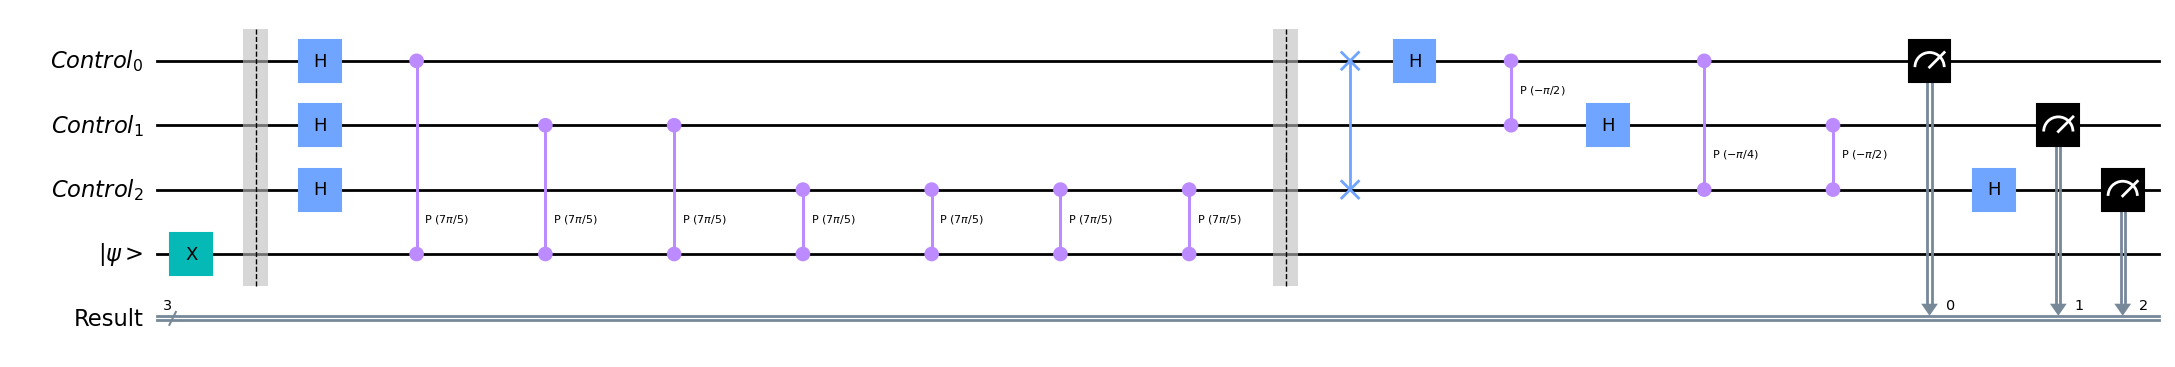

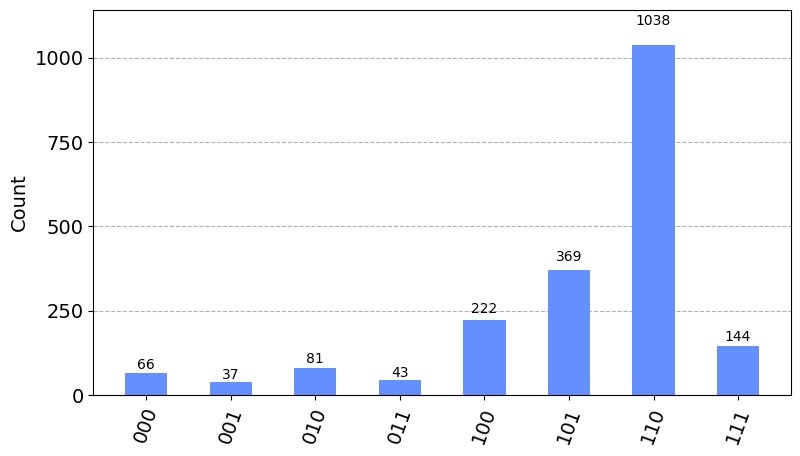

In [13]:
from qiskit.providers.fake_provider import FakeManilaV2
from qiskit.compiler import transpile

backend = FakeManilaV2() 

max_depth_qpe = qc
min_depth_qpe = qc

for times in range(15):
    
    ph_qc = transpile(qc, backend = backend)
    
    ph_depth = ph_qc.depth()
    if max_depth_qpe.depth() < ph_depth: max_depth_qpe = ph_qc
    elif min_depth_qpe.depth() > ph_depth : min_depth_qpe = ph_qc

shots = 2000

# run the minimum depth qpe circuit
job_min_qpe4 = backend.run(min_depth_qpe, shots=shots)
display(min_depth_qpe.draw('mpl',fold=-1))

# gather the count data
count_min_qpe4 = job_min_qpe4.result().get_counts()
plot_histogram(count_min_qpe4, figsize=(9,5))

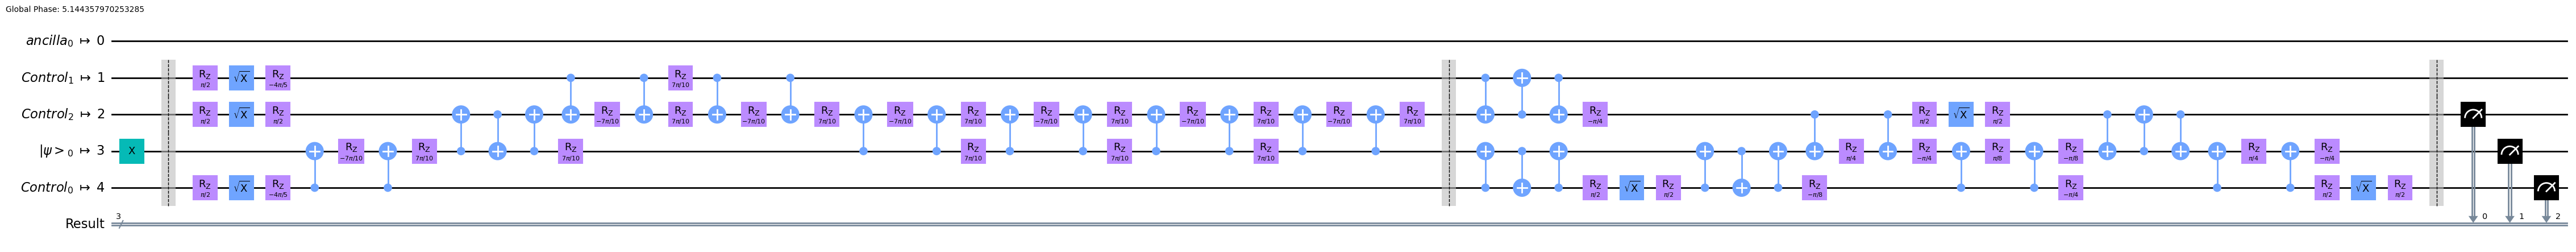

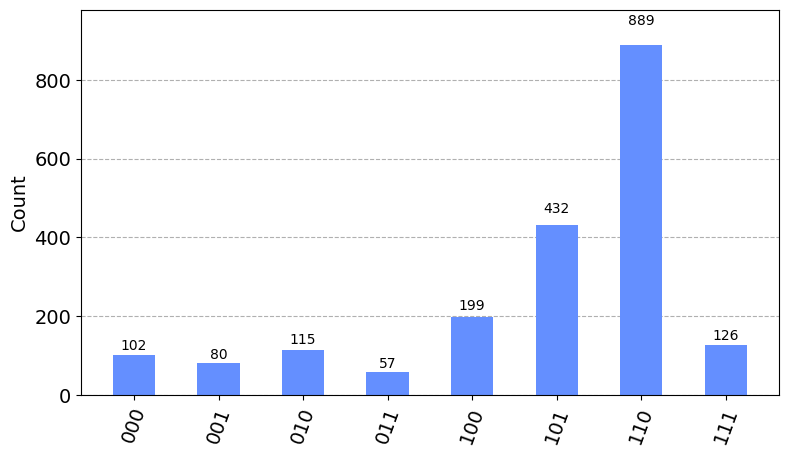

In [14]:
# run the maximum depth qpe circuit
job_max_qpe4 = backend.run(max_depth_qpe, shots=shots)
display(max_depth_qpe.draw('mpl',fold=-1))

# gather the count data
count_max_qpe4 = job_max_qpe4.result().get_counts()
plot_histogram(count_max_qpe4, figsize=(9,5))

***
## Iterative Phase Estimation
***

Abbiamo appena visto la Quantum Phase Estimation, uno dei più importanti algoritmi quantistici, elemento cardine di moltissimi algoritmi come subroutine quantistica. La sua implementazione più diretta richiede un numero crescente di qubit (logici) ausiliari per ottenere la precisione desiderata, ma questa richiesta di risorse definisce dei circuiti che sono difficili da eseguire sugli hardware rumorosi attuali, dotati di una limitata connettività.

É stata dunque definita una variante iterativa, chiamata per l'appunto **Iterative Phase Estimation (IPE)**, che richiede *un solo qubit* ausiliario. Nell'IPE, il qubit ausiliario è misurato ripetutamente, con i risultati di tale misurazione utilizzati per indirizzare le successive operazioni quantistiche. Questo tipo di programmazione *feed-forward* era precedentemente non eseguibile sui processori quantistici dell'IBM, ma recenti sviluppi hanno permesso di introdurre **circuiti dinamici** di questo tipo.

Assumiamo per ora che $\theta$ abbia un'espansione binaria esatta, ossia
$$
    \theta = \frac{\theta_1}{2} + \frac{\theta_2}{2^2} + \cdots + \frac{\theta_m}{2^m} = 0.\theta_1\theta_2\ldots\theta_m
$$
Per semplicità, supponiamo inoltre che l'operazione unitaria $\mathbf{U}$ agisca solo su un qubit: dato che necessitiamo di un qubit ausiliario, il nostro circuito avrà due qubit $q_0,q_1$, dove $q_0$ è il qubit ausiliario e $q_1$ rappresenta il sistema su cui agisce $\mathbf{U}$.

Ora, supponiamo di inizializzare $q_0$ nello stato $|+\rangle = \frac{|0\rangle + |1\rangle}{\sqrt{2}}$ e $q_1$ nello stato $|\psi\rangle$, dove stiamo sempre assumendo che $|\psi\rangle$ sia autovettore di $\mathbf{U}$. Vediamo cosa succede applicando $\mathbf{CU}$ con $q_0$ come controllo e $q_1$ come target:
$$
    \begin{align*}
        |\Psi \rangle |+\rangle &=  |\Psi \rangle \left(\frac{|0\rangle + |1\rangle}{\sqrt{2}}\right)\\
        &= \frac{|\Psi\rangle |0\rangle  + |\Psi \rangle|1\rangle }{\sqrt{2}} \\
        \xrightarrow{\text{controlled-}U^{2^t}} &\:\frac{|\Psi \rangle|0\rangle  + e^{i 2 \pi 2^{t} \theta}|\Psi \rangle |1\rangle}{\sqrt{2}} \\
        &= |\Psi \rangle \left(\frac{|0\rangle  + e^{i 2 \pi 2^{t} \theta} |1\rangle}{\sqrt{2}}\right)
    \end{align*}
$$
ossia, lo stato del sistema resta inalterato, mentre una fase pari a $e^{i 2 \pi 2^{t} \theta}$ è stata "kicked back" nello stato del qubit ausiliario.

Osserviamo ora che
$$
    e^{i 2 \pi 2^{t} \theta} = e^{i 2 \pi 2^{t} (0.\theta_1 \theta_2 \cdots \theta_m)}
    = e^{i 2 \pi (\theta_1 \cdots \theta_t . \theta_{t + 1} \cdots \theta_m)}
    = e^{i 2 \pi (0. \theta_{t + 1} \cdots \theta_m)}
$$
dove nell'ultima uguaglianza l'intera parte "decimale" della rappresentazione di fase è sparita dato che $e^{i 2\pi n} = 1$ per ogni intero $n$.
Ad esempio:
* per $t=0$, la fase sarebbe $e^{i 2 \pi 2^{0} \theta} = e^{i 2 \pi \theta} = e^{i 2 \pi 0.\theta_1 \theta_2 ... \theta_m}$;
* per $t=1$, la fase sarebbe $e^{i 2 \pi 2^{1} \theta}= e^{i 2 \pi \theta_1} e^{i 2 \pi 0.\theta_2 \theta_3 ... \theta_m} = e^{i 2 \pi 0.\theta_2 \theta_3 ... \theta_m}$;
* per $t=2$, la fase sarebbe $e^{i 2 \pi 2^{2} \theta} = e^{i 2 \pi 0.\theta_3 \theta_4 ... \theta_m}$;
* per $t=m-1$, la fase sarebbe $e^{i 2 \pi 2^{m-1} \theta} = e^{i 2 \pi 0.\theta_m}$.

Osserviamo che per $t=m-1$ la fase è pari a $1$ se $\theta_m=0$ e $-1$ se $\theta_m = 1$: ciò vuol dire che, nel primo caso, il qubit ausiliario $q_0$ sarebbe nello stato $|+\rangle = \frac{|0\rangle + |1\rangle}{\sqrt{2}}$, mentre nel secondo sarebbe nello stato $|-\rangle = \frac{|0\rangle - |1\rangle}{\sqrt{2}}$. Dunque, misurare il qubit nella base di Pauli $\mathbf{X}$ ci permette di distinguere i casi con il $100%$ di successo, applicando un gate Hadamard prima di effettuare la misurazione e ottenendo così che il nostro output sia esattamente pari a $\theta_m$.

### L'algoritmo

Nel primo step, misuriamo direttamente il bit meno significativo $\theta_m$ della fase $\theta$, inizializzando il registro a due qubit come appena descritto per poi applicare l'operazione controllata $\mathbf{Controlled-U^{m-1}}$ e infine misurare $q_0$ nella base di Pauli $\mathbf{X}$. 

Nel secondo step, inizializziamo il sistema nello stesso modo e applichiamo l'operazione $\mathbf{Controlled-U^{m-2}}$. La fase relativa in $q_0$ dopo queste operazioni è ora $e^{i 2 \pi 0.\theta_{m-1}\theta_{m}}= e^{i 2 \pi 0.\theta_{m-1}} e^{i 2 \pi \theta_m/4}$. 
Per estrarre il bit $\theta_{m-1}$, dobbiamo innanzitutto effettuare una rotazione di correzione intorno all'asse $Z$ di un angolo pari a $-2 \pi \theta_m/4=-\pi \theta_m/2$, che fa sì che lo stato di $q_0$ diventi $|0\rangle + e^{i 2 \pi 0.\theta_{m-1}} | 1 \rangle$.
A questo punto possiamo effettuare la nostra misurazione ed estrarre l'informazione che vogliamo.

Dunque, in generale, il $k$-esimo passo dell'IPE per ottenere $\theta_{m-k+1}$ consiste nell'inizializzare i registri sempre nello stesso modo per poi applicare $\mathbf{Controlled-U^{m-k}}$ seguita da una rotazione di correzione di angolo $\omega_k = -2 \pi 0.0\theta_{m-k+2} ... \theta_m$ e infine misurare $q_0$ nella base $\mathbf{X}$ (i.e. Hadamard seguito da misurazione nella base standard).

Osserviamo che $q_1$ rimane nello stato $|\psi\rangle$ per tutto l'algoritmo.

### Implementazione

Vediamo ora come implementare l'IPE su un gate $\mathbf{S}$, che ricordiamo essere definito come
$$ 
    S =
    \begin{pmatrix}
        1 & 0\\
        0 & e^{i\pi / 2}
    \end{pmatrix}
$$

Useremo come autovettore lo stato $|\psi\rangle = |1\rangle$, che è associato all'autovalore $e^{i\pi/2}= e^{i2\pi \cdot 1/4}$. In questo modo abbiamo 
$$
    \theta = 1/4 = 0.01 = 0.\theta_1 \theta_2
$$
Dato che $\theta$ può essere rappresentato esattamente con $2$ bit, il nostro circuito quantistico avrà un registro classico a due bit per salvare tale informazione.

Il gate controllato $\mathbf{CS}$ può essere implementato usando il controlled phase gate, disponibile in Qiskit e applicabile chiamando il metodo `.cp` di un oggetto `QuantumCircuit`. Ricordiamo la forma matriciale di questo gate:
$$
        \text{CPhase}(\alpha) =
            \begin{pmatrix}
                1 & 0 & 0 & 0 \\
                0 & 1 & 0 & 0 \\
                0 & 0 & 1 & 0 \\
                0 & 0 & 0 & e^{i\alpha}
            \end{pmatrix}
$$

**Ex.3 - Implementare il primo step dell'algoritmo**

Vogliamo ottenere il bit meno significativo di $\theta$ e possiamo farlo tramite i seguenti passi:
1. Inizializzazione dei qubit:
      - Hadamard sul qubit ausiliario
      - $\mathbf{X}$ gate sul qubit di sistema
2. Applicazione di $\mathbf{CS}$ con l'angolo corretto
3. Misurazione del qubit ausiliario rispetto alla base $\mathbf{X}$:
      - Hadamard sul qubit ausiliario
      - Misurazione nella base standard

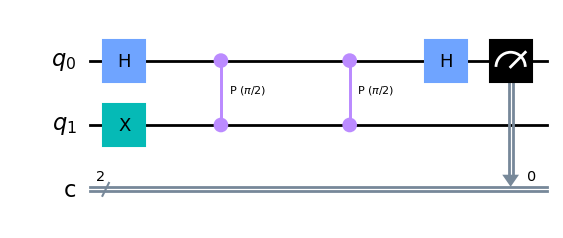

In [15]:
def step_1_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:

    # qr is a quantum register with 2 qubits
    # cr is a classical register with 2 bits

    qc = QuantumCircuit(qr, cr)

    ######################################
    # add your code here
    
    # init
    qc.h(0)
    qc.x(1)

    # CU
    qc.cp(np.pi/2, 0, 1)
    qc.cp(np.pi/2, 0, 1)
    
    # measure in X
    qc.h(0)
    qc.measure(0,0)

    ######################################

    return qc

# main
qr = QuantumRegister(2, "q")
cr = ClassicalRegister(2, "c")
qc = QuantumCircuit(qr, cr)
qc = step_1_circuit(qr, cr)
qc.draw("mpl")

**Ex.4 - Implementare il secondo step dell'algoritmo**

In questo secondo e ultimo step estrarremo il bit successivo $\theta_1$. A tal fine, dovremo applicare una rotazione di correzione il cui valore dipenderà dal registro classico su cui abbiamo salvato $\theta_2$.

Per applicare la correzione di fase potete utilizzare il `PhaseGate` o chiamare direttamente il metodo `.p` di un `Qunatum Circuit`.

Partendo dal circuito definito nello step precedente, applicheremo le seguenti operazioni:
1. Resettiamo e re-inizializziamo il qubit ausiliario;
2. Applichiamo $\mathbf{CU}$;
3. Misuriamo rispetto alla base di Pauli $\mathbf{X}$

Dato che la correzione di fase è condizionata al valore di $\theta_2$, vi servirà nuovamente il metodo `QuantumCircuit.if_else` ([link](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.html#qiskit.circuit.QuantumCircuit.if_else)), di cui potete trovare tutte le informazioni al link associato.

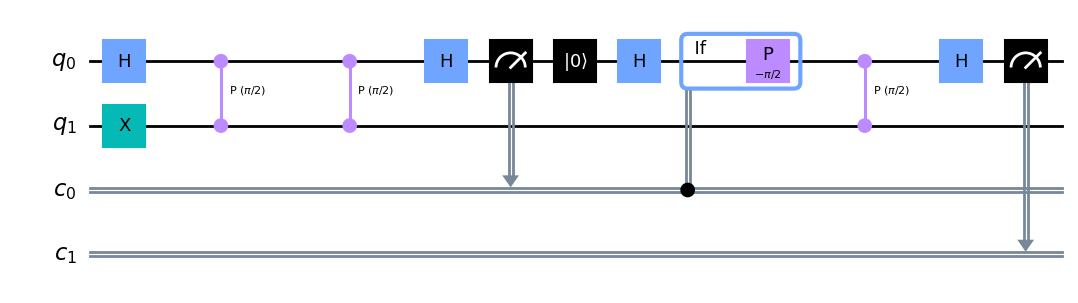

In [16]:
def step_2_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:

    # qr is a quantum register with 2 qubits
    # cr is a classical register with 2 bits

    # begin with the circuit from Step 1
    qc = step_1_circuit(qr, cr)

    qc.reset(0)

    ######################################
    # add your code here
    
    # init
    qc.h(0)
    
    # correction
    with qc.if_test((cr[0], 1)) as else_:
        qc.p(-np.pi/2, 0)

    # CU
    qc.cp(np.pi/2, 0, 1)
    
    # measure in X
    qc.h(0)
    qc.measure(0,1)

    ######################################

    return qc


qr = QuantumRegister(2, "q")
cr = ClassicalRegister(2, "c")
qc = QuantumCircuit(qr, cr)
qc = step_2_circuit(qr, cr)
qc.draw("mpl")

### Simulazione

Ora che abbiamo il circuito completo, eseguiamolo su un simulatore locale.

In [17]:
from qiskit_aer import AerSimulator

sim = AerSimulator()
job = sim.run(qc, shots=1000)
result = job.result()
counts = result.get_counts()
counts

{'01': 1000}

Se il circuito è corretto, otterremo la stringa $01$ con il $100%$ di probabilità: tale valore corrisponde alla fase scritta come $\theta = 0.01 = 1/4$, ossia la fase corretta!

### E se la fase non avesse un'espansione binaria precisa?

Consideriamo ora il caso in cui $\theta$ non sia rappresentabile come scrittura binaria esatta, come ad esempio $\theta = 1/3$, la cui espansione binaria è infinita:
$$
    1/3 = 0.010101\ldots
$$
In questo caso, il gate a singolo qubit è della forma
$$ 
    U =
    \begin{pmatrix}
        1 & 0\\
        0 & e^{i2\pi / 3}
    \end{pmatrix}
$$

Nella pratica, in ogni caso, lavoreremo con un numero finito e fissato di bit di precisione e dunque il nostro obiettivo sarà di ottenere il valore più veritiero possibile usando quei bit. Nel seguente esempio, useremo due bit di precisione, ottenendo che il valore più vicino al valore corretto sia $0.01 = 1/4$. Dato che questo valore non rappresenta esattamente la fase, c'è la possibilità di ottenere un risultato diverso, ancora meno preciso.

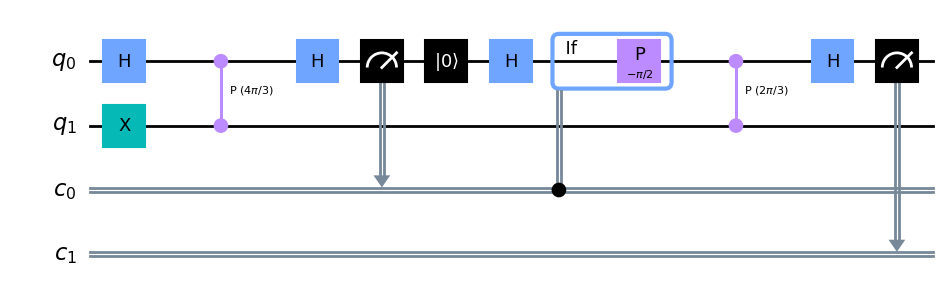

In [18]:
def u_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:

    # qr is a quantum register with 2 qubits
    # cr is a classical register with 4 bits

    qc = QuantumCircuit(qr, cr)

    # Initialization
    q0, q1 = qr
    qc.h(q0)
    qc.x(q1)

    # Apply control-U operator as many times as needed to get the least significant phase bit
    u_angle = 2 * np.pi / 3
    k = 1
    cphase_angle = u_angle * 2**k
    qc.cp(cphase_angle, q0, q1)

    # Measure the auxiliary qubit in x-basis into the first classical bit
    qc.h(q0)
    c0, c1 = cr
    qc.measure(q0, c0)

    # Reset and re-initialize the auxiliary qubit
    qc.reset(q0)
    qc.h(q0)

    # Apply phase correction conditioned on the first classical bit
    with qc.if_test((c0, 1)):
        qc.p(-np.pi / 2, q0)

    # Apply control-U operator as many times as needed to get the next phase bit
    k = 0
    cphase_angle = u_angle * 2**k
    qc.cp(cphase_angle, q0, q1)

    # Measure the auxiliary qubit in x-basis into the second classical bit
    qc.h(q0)
    qc.measure(q0, c1)

    return qc


qr = QuantumRegister(2, "q")
cr = ClassicalRegister(2, "c")
qc = QuantumCircuit(qr, cr)
qc = u_circuit(qr, cr)
qc.draw("mpl")

In [19]:
from qiskit_aer import AerSimulator

sim = AerSimulator()
job = sim.run(qc, shots=1000)
result = job.result()
counts = result.get_counts()
print(counts)
success_probability = counts["01"] / counts.shots()
print(f"Success probability: {success_probability}")

{'11': 40, '01': 728, '10': 175, '00': 57}
Success probability: 0.728


Come ci aspettavamo, c'è una probablità non nulla di ottenere un risultato errato. Ma come possiamo aumentare la probabilità di successo?

Un possibile primo errore si verifica quando il circuito misura incorrettamente il primo bit. In questo caso, la correzione di fase è a sua volta incorretta, generando così un effetto a cascata sulle misurazioni successive. Un modo semplice di mitigare tale problema è di ripetere la misurazione del primo bit diverse volte e prendere come valore per esso la maggioranza tra i risultati. Implementare questa procedura su un singolo circuito richiederebbe di eseguire alcuni calcoli sulle misurazioni ottenute, ma su Qiskit tali aritmetiche non sono al momento supportate: useremo dunque diversi circuiti per effettuare le misurazioni, così da ottenere il miglioramento che desideriamo.

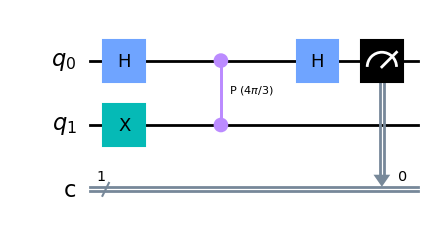

In [20]:
def u_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 1 bits

    qc = QuantumCircuit(qr, cr)

    # Initialization
    q0, q1 = qr
    qc.h(q0)
    qc.x(q1)

    # Apply control-U operator as many times as needed to get the least significant phase bit
    u_angle = 2 * np.pi / 3
    k = 1
    cphase_angle = u_angle * 2**k
    qc.cp(cphase_angle, q0, q1)

    # Measure the auxiliary qubit in x-basis
    qc.h(q0)
    (c0,) = cr
    qc.measure(q0, c0)

    return qc


qr = QuantumRegister(2, "q")
cr = ClassicalRegister(1, "c")
qc = QuantumCircuit(qr, cr)
qc = u_circuit(qr, cr)
qc.draw("mpl")

In [21]:
job = sim.run(qc, shots=117)
result = job.result()
counts = result.get_counts()
print(counts)

{'0': 26, '1': 91}


Se tutto va bene, il bit corretto sarà misurato più volte di quello errato.

**Ex.5 - Costruire il circuito che misura il secondo bit della fase.**

Sostituite la prima parte del circuito con una che semplicemente prepara il qubit ausiliario nel valore che abbiamo appena misurato, così che la misurazione del primo qubit sia sempre corretta.

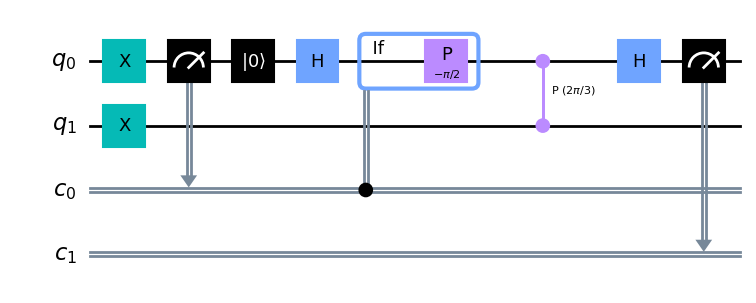

In [22]:
def u_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 2 bits

    qc = QuantumCircuit(qr, cr)

    ######################################
    # add your code here

    # angle
    u_angle = 2 * np.pi / 3
    
    ### iter1
    # init
    qc.x(1)
    qc.x(0)

    # measure
    qc.measure(0,0)
    
    ### iter2
    # init
    qc.reset(0)
    qc.h(0)
    
    # correction
    with qc.if_test((cr[0], 1)) as else_:
        qc.p(-np.pi / 2, 0)

    # CU
    k = 0
    cphase_angle = u_angle * 2**k
    qc.cp(cphase_angle, 0, 1)
    
    # measure in X
    qc.h(0)
    qc.measure(0,1)

    ######################################
    
    return qc


qr = QuantumRegister(2, "q")
cr = ClassicalRegister(2, "c")
qc = QuantumCircuit(qr, cr)
qc = u_circuit(qr, cr)
qc.draw("mpl")

In [23]:
sim = AerSimulator()

job = sim.run(qc, shots=1000)
result = job.result()
counts = result.get_counts()
print(counts)

success_probability = counts["01"] / counts.shots()
print(f"Success probability: {success_probability}")

{'11': 65, '01': 935}
Success probability: 0.935


***
## Quantum Counting
***

La scorsa lezione abbiamo visto l'algoritmo di Grover, il cui scopo era trovare una soluzione qualunque tra le $k$ disponibili (se esistono). Ma se invece non fossimo interessati al valore della soluzione ma solo al loro numero?

Il Quantum Counting è un algoritmo che si basa sull'oracolo di Grover e sulla QPE per ottenere una stima del numero di soluzioni, basandosi sulla fase dello stato iniziale $|s\rangle$ nella'algoritmo di Grover.

### Intuizione

Riprendiamo il primo step dell'algoritmo di Grover, ossia l'inizializziazione del nostro stato alla sovrapposizione equiprobabile degli stati $|s\rangle$:

<center>

<img src="./images/Grover1PC.png" alt="grover" width="300"/>

</center>

La percentuale di soluzioni nel nostro spazio di ricerca influenzerà la differenza tra $|s\rangle$ e $|l\rangle$: ad esempio, se non ci sono molte soluzioni $|s\rangle$ sarà più vicino a $|s\rangle$ e $\theta$ sarà molto piccolo.

Possiamo dunque cercare di stimare $\theta$ tramite QPE e ottenere un valore approssimato del numero di soluzioni presenti.

### Più nel dettaglio

Nella base $\left\{|w\rangle,|l\rangle \right\}$, possiamo scrivere un'iterazione dell'algoritmo di Grover come
$$
    \mathbf{G} = 
    \begin{bmatrix}
        \cos(\varphi) & -\sin(\varphi) \\
        \sin(\varphi) & \cos(\varphi)
    \end{bmatrix}
$$
dove $\varphi = 2\theta$.
Tale matrice ha autovettori pari a 
$$
    \begin{pmatrix}
        -i \\ 
        1
    \end{pmatrix}   
    \qquad 
    \begin{pmatrix}
        i \\ 
        1
    \end{pmatrix} 
$$
i cui autovalori associati sono $e^{\pm i \varphi}$. Dato che $|s\rangle$ è nello span dei vettori |w\rangle,|l\rangle, tale stato sarà una sovrapposizione di essi, ossia
$$
    |s\rangle = \alpha|w\rangle + \beta |l\rangle
$$
Dunque l'output della QPE sarà una sovrapposizione delle due fasi e misurando otterremo uno dei due possibili autovalori. A questo punto ci basterà un po' di matematica per ottenere la stima di $k$ che vogliamo!

### Implementazione

Nel seguente esempio, supporremo di *contare* sui primi $4$ qubit e di effettuare la ricerca delle soluzioni sugli ultimi $4$. 

Supporremo inoltre che ci siano $5$ soluzioni su $16$ per costruire facilmente l'oracolo, ma abbiamo già visto come si possa costruire un oracolo partendo da una funzione $f$ di controllo e dunque sappiamo che tale ragionamento si può generalizzare senza troppi problemi.

La prima operazione che ci serve è l'iterazione di Grover controllata, che definiamo  partendo da quella semplice nel seguente modo:

In [24]:
# grover iteration
from qiskit.circuit.library import Diagonal, GroverOperator

def grover_operator(n_iterations) -> Gate:

    """Grover iteration circuit for oracle with 5/16 solutions
        Args:
            n_iterations (int): number of times to repeat the circuit
        Returns:
            Gate that implements n_iterations of the Grover operator
    """

    oracle = Diagonal([1,1,-1,1,1,1,1,-1,1,1,-1,-1,1,1,-1,1])
    grover_it = GroverOperator(oracle).repeat(n_iterations).to_gate()
    grover_it.label = f"Grover$^{n_iterations}$"

    return grover_it

Per la QPE ci servirà anche la QFT inversa, dunque prepariamo il gate associato:

In [25]:
# inverse QFT
from qiskit.circuit.library import QFT

qft_dagger = QFT(4, inverse=True).to_gate()
qft_dagger.label = "QFT†"

Siamo dunque pronti per costruire il circuito completo!

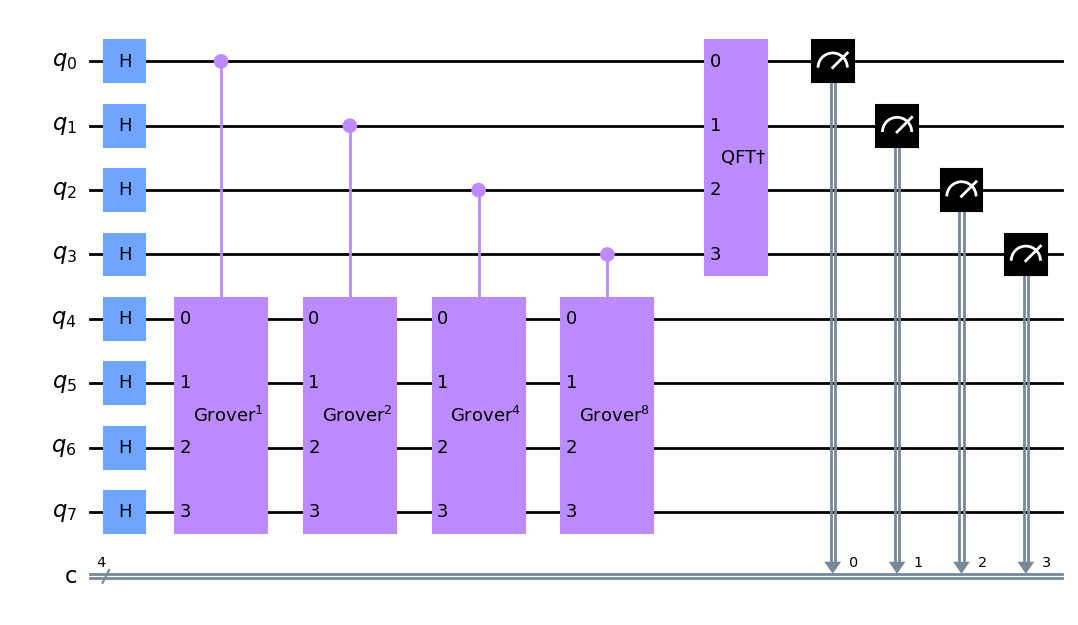

In [26]:
# Create QuantumCircuit
t = 4   # no. of counting qubits
n = 4   # no. of searching qubits
qc = QuantumCircuit(n+t, t) # Circuit with n+t qubits and t classical bits

# Initialize all qubits to |+>
for qubit in range(t+n):
    qc.h(qubit)

# Begin controlled Grover iterations
n_iterations = 1
for qubit in range(t):
    cgrit = grover_operator(n_iterations).control()
    qc.append(cgrit, [qubit] + list(range(t, n+t)))
    n_iterations *= 2
    
# Do inverse QFT on counting qubits
qc.append(qft_dagger, range(t))

# Measure counting qubits
qc.measure(range(t), range(t))

# Display the circuit
qc.draw('mpl', fold=-1)

### Simulazione
Vediamo cosa succede in simulazione:

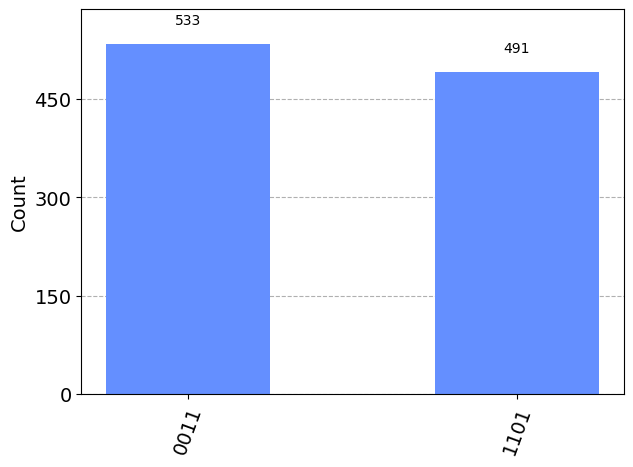

In [27]:
# Execute and see results
sim = Aer.get_backend('aer_simulator')

transpiled_qc = transpile(qc, sim)
job = sim.run(transpiled_qc)

hist = job.result().get_counts()
plot_histogram(hist)

Notiamo che ci sono due valori che si distinguono tra tutti gli altri possibili output della misurazione e questi sono i valori corrispondenti a $e^{\pm i\varphi}$. Non ci resta che elaborare tale informazione per ottenere il numero intero $k$ che stiamo cercando.

In [28]:
# fix the most measured string
measured_str = max(hist, key=hist.get)

# turn into a in integer
measured_int = int(measured_str, 2)
print("Register Output = %i" % measured_int)

Register Output = 3


Definiamo ora una funzione che calcoli $k$ partendo da questo intero, dal numero di counting qubit e dal numero di qubit per la ricerca.

Dalla QPE otterremo un valore pari a $2^n \phi$ e dunque per ottenere $\varphi$ dovremmo innanzitutto porre
$$
    2\theta \equiv \varphi = 2^n \phi \cdot \frac{2\pi}{2^t}
$$
ossia

In [29]:
phi = (measured_int/(2**t))*pi*2
print("Phi = %.5f" % phi)

Phi = 1.17810


Dalla geometria sappiamo che possiamo ottenere il nostro angolo $\theta$ come
$$
    \langle l \vert s \rangle = \cos(\theta)
$$
Inoltre possiamo scrivere
$$
    |s\rangle = \sqrt{\frac{k}{N}} |w\rangle + \sqrt{\frac{N-k}{N}} |l\rangle
$$
da cui otteniamo che
$$
    \langle l \vert s \rangle = \sqrt{\frac{N-k}{N}} = \cos(\theta)
$$
Tramite qualche passaggio di trigonometria (che non approfondiremo oltre), otteniamo infine che
$$
    N \sin^2(\theta) = k
$$

In [30]:
N = 2**n
theta = phi/2
k = N * (sin(theta)**2)
print(f"No. of Solutions = {k:.1f}")

No. of Solutions = 4.9


Che vediamo essere il risultato corretto!

Per completezza, riportiamo la funzione completa per calcolare $k$:

In [31]:
def calculate_M(measured_int, t, n):

    """For Processing Output of Quantum Counting"""

    # Calculate phi
    theta = (measured_int/(2**t))*pi*2
    print("Phi = %.5f" % phi)

    # Calculate No. of Solutions
    N = 2**n
    theta = phi/2
    M = N * (sin(theta/2)**2)
    print(f"No. of Solutions = {M:.1f}")

***
## L'algoritmo di Shor
***

Costruiremo ora le funzioni necessarie ad implementare l'algoritmo di Shor, il cui obiettivo è trovare i fattori primi di un numero $N$ e il cui speedup è dovuto alla subroutine quantistica relativa alla ricerca del periodo.

Gli step dell'algoritmo sono:
1. Scegliere $a$ coprimo con $N$ tale che $a\in[2,N-1]$;
2. Trovare il periodo (l'ordine) di $a$ modulo $N$, ossia il più piccolo intero $r$ tale che $a^r\text{mod} N=1$;
3. Calcolare l'mcd tra $a^{r/2} \pm 1$ e $N$ per ottenere un fattore di $N$.

### Step 1: Trovare il periodo

Useremo l'operatore 
$$ 
    \mathbf{U}|y\rangle{} \equiv |ay\ \text{mod} N\rangle
$$
ed esploreremo la seguente sovrapposizione:
$$
    |u\rangle{} = \frac{1}{\sqrt{r}}\sum_{k=0}^{r-1} e^{-\frac{2\pi ik}{r}}|a^k \text{mod}N\rangle
$$

Fissiamo $a = 3$ e $N=35$ per esempio e vediamo l'azione di $\mathbf{U}$ su $|u\rangle$:
$$
\begin{align*}
    \mathbf{U}|u\rangle{} &= \mathbf{U}\frac{1}{\sqrt{r}}\left( |1\rangle{} + e^{-\frac{2\pi i}{r}}|3\rangle{} + e^{\frac{-4\pi i}{r}}|9\rangle{} + ... + e^{\frac{-20\pi i}{r}}|4\rangle{} + e^{\frac{-22\pi i}{r}}|12\rangle{} \right) \\
    & =\frac{1}{\sqrt{r}}\left( \mathbf{U}|1\rangle{} + e^{-\frac{2\pi i}{r}}\mathbf{U}|3\rangle{} + e^{\frac{-4\pi i}{r}}\mathbf{U}|9\rangle{} + ... + e^{\frac{-20\pi i}{r}}\mathbf{U}|4\rangle{} + e^{\frac{-22\pi i}{r}}\mathbf{U}|12\rangle{} \right) \\
    &= \frac{1}{\sqrt{r}}\left( |3\rangle{} + e^{-\frac{2\pi i}{r}}|9\rangle{} + e^{\frac{-4\pi i}{r}}|27\rangle{} + ... + e^{\frac{-20\pi i}{r}}|12\rangle{} + e^{\frac{-22\pi i}{r}}|1\rangle{} \right) \\
    &= \frac{e^{\frac{2\pi i}{r}}}{\sqrt{r}}\left( e^{-\frac{2\pi i}{r}}|3\rangle{} + e^{\frac{-4\pi i}{r}}|9\rangle{} + ... + e^{\frac{-20\pi i}{r}}|4\rangle{} + e^{\frac{-22\pi i}{r}}|12\rangle{} + |1\rangle{} \right) \\
    &= \frac{e^{\frac{2\pi i}{r}}}{\sqrt{r}} |u\rangle{}.
\end{align*}
$$

Questo autovalore in particolare (che non è unico) ci è molto utile perché contiene $r$. Infatti, dobbiamo essere sicuri che sia presente così da poter garantire che le differenze di fase tra gli stati della base siano uguali. Per generalizzare ulteriormente, possiamo moltiplicare per un intero $s$ ognuna di queste fasi, valore che si trasferirà nei nostri autovalori:
$$
\begin{align*}
    |u_s\rangle{} &= \frac{1}{\sqrt{r}}\sum_{k=0}^{r-1} e^{\frac{-2\pi isk}{r}}|a^k\text{mod} N\rangle{} \\
    \mathbf{U}|u_s\rangle{} &= e^{\frac{2\pi is}{r}}|u_s\rangle{}.
\end{align*}
$$

In questo modo, abbiamo un autovettore per ogni intero $0\leq s\leq r$. É importante osservare che se sommiamo tutti gli autovettori le fasi cancellano tutti gli stati della base ad eccezione di $|1\rangle{}$ 
$$ 
    \frac{1}{\sqrt{r}} \sum_{s=0}^{r-1}|u_s\rangle{} = |1\rangle{} 
$$

Dato che ogni stato della base computazionale può essere scritto come combinazione lineare di questi autovettori, se effettuiamo una QPE su $\mathbf{U}$ usando lo stato $|1\rangle$, misureremo una fase 
$$
    \phi = \frac{s}{r}
$$
dove $s$ è un numero intero aleatorio tra $0$ e $r-1$.

In fine, possiamo applicare il metodo delle frazioni continue su $\phi$ per ottenere $r$.

Di seguito, presentiamo l'operatore unitario $\mathbf{U}$ necessario per risolvere il problema del periodo per $a=7$ e $N=15$:
$$ 
    U|y\rangle{} = |7y\text{ mod}15\rangle{}.
$$

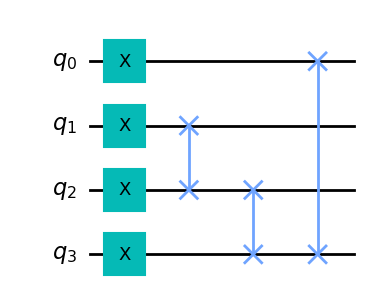

In [32]:
## Create 7mod15 gate
N = 15
m = int(np.ceil(np.log2(N)))

U_qc = QuantumCircuit(m)
U_qc.x(range(m))
U_qc.swap(1, 2)
U_qc.swap(2, 3)
U_qc.swap(0, 3)

U = U_qc.to_gate()
U.name ='{}Mod{}'.format(7, N)

U_qc.draw('mpl')

**Ex.6 - Verficare il funzionamento di $\mathbf{U}$**

Assicuratevi che tale operatore funzioni come vogliamo creando tre circuiti con $m=4$ qubit: preparate lo stato di input $|y\rangle$ rappresentando un intero tra $0$ e $15$ cpme stringa binaria (e.g. $|1\rangle{} = |0001\rangle{}$, $|5\rangle{} = |0101\rangle{}$, etc...) e poi applicate $\mathbf{U}$. 

In particolare, testate l'output del circuito sugli stati $|1\rangle{}$, $|2\rangle{}$, and $|5\rangle{}$. Ad esempio, per $|2\rangle$ il risultato dovrebbe essere  $|14\rangle{}=|1110\rangle{}$.

Eseguite questi circuiti sul backend `aer_simulator` con $20000$ shots.

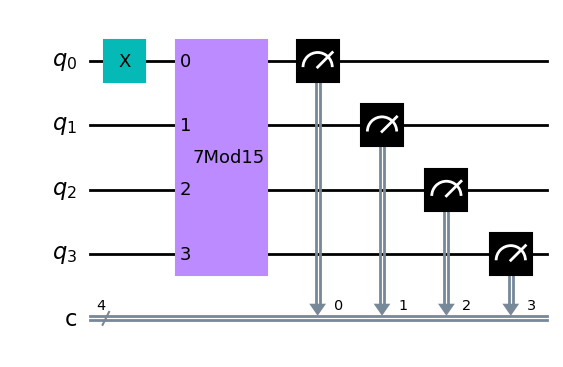

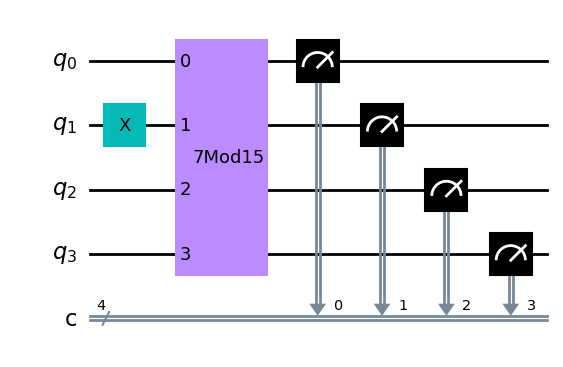

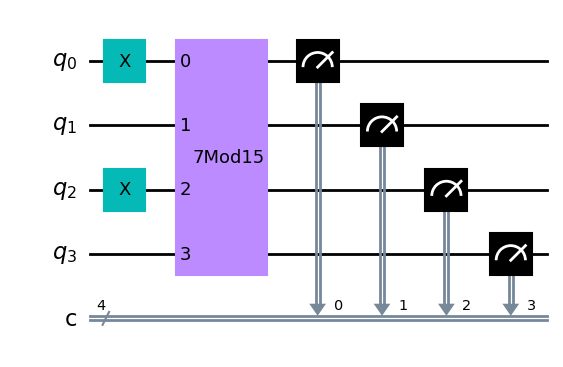

In [37]:
### your code goes here

############################### |1>

qcirc = QuantumCircuit(m,m)

qcirc.x(0)

qcirc.append(U,[0,1,2,3])

for i in range(m):
    qcirc.measure(i,i)
    
display(qcirc.draw("mpl"))

############################### |2>

qcirc2 = QuantumCircuit(m,m)

qcirc2.x(1)

qcirc2.append(U,[0,1,2,3])

for i in range(m):
    qcirc2.measure(i,i)
    
display(qcirc2.draw("mpl"))

############################### |5>

qcirc5 = QuantumCircuit(m,m)

qcirc5.x(0)
qcirc5.x(2)

qcirc5.append(U,[0,1,2,3])

for i in range(m):
    qcirc5.measure(i,i)

display(qcirc5.draw("mpl"))

In [44]:
## Run this cell to simulate
sim = Aer.get_backend('aer_simulator')
shots = 20000

input_1 = execute(qcirc, sim, shots=shots).result().get_counts()  # save the count data for input 1
input_2 = execute(qcirc2, sim, shots=shots).result().get_counts() # save the count data for input 2
input_5 = execute(qcirc5, sim, shots=shots).result().get_counts() # save the count data for input 5


In [45]:
print(input_1.int_outcomes(), input_2.int_outcomes(), input_5.int_outcomes())

{7: 20000} {14: 20000} {5: 20000}


### Step 2: implementare $U^{2^{m-1}}$

Useremo ora $\mathbf{CU}$ per stimare la fase $\phi=\frac{s}{r}$, proprio come nella QPE. L'osservazione importante da fare è che applicare i gate `7Mod15` un multiplo di $4$ volte genera l'identità, come è possibile provare costruendo un semplice circuito:

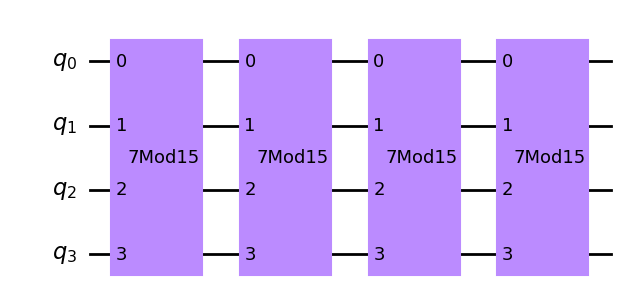

In [46]:
unitary_circ = QuantumCircuit(m)

for i in range(4):
    unitary_circ.append(U,[j for j in range(m)])
    
unitary_circ.draw("mpl")

In [47]:
sim = Aer.get_backend('unitary_simulator')
unitary = execute(unitary_circ, sim).result().get_unitary()
array_to_latex(unitary)

<IPython.core.display.Latex object>

### Step 3 : trovare $\phi$ e le frazioni continue

Avendo ora trovato come eseguire $U^{2^{m-1}}$, usiamolo nel circuito QPE per stimare la fase. Di seguito trovate una funzione che costruisce il gate $\mathbf{CU}$, che usa $8$ qubit per i registri di fase e $4$ qubit su cui fare agire $\mathbf{U}$.

Usando nuovamente `aer_simulator`, stimate dunque $\phi$ avendo in input $|1\rangle$.

*Suggerimento: ad ogni iterazione nel circuito della QPE dovrete costruire un nuovo circuito `cU_multi` e "appenderlo" al circuito della QPE. Ci saranno inoltre diverse stime con probabilità pressocché uguali*

In [48]:
#This function will return a ControlledGate object which 
# repeats the action of U, 2^k times
def cU_multi(k):

    sys_register_size = 4
    circ = QuantumCircuit(sys_register_size)

    for _ in range(2**k):
        circ.append(U, range(sys_register_size))
    
    U_multi = circ.to_gate()
    U_multi.name = '7Mod15_[2^{}]'.format(k)
    
    cU_multi = U_multi.control()
    
    return cU_multi

In [49]:
cU_multi(5)

Instruction(name='c7Mod15_[2^5]', num_qubits=5, num_clbits=0, params=[])

In [50]:
def qft_dagger_1(n):

    """n-qubit QFTdagger the first n qubits in circ"""

    qc = QuantumCircuit(n)

    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)

    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
        
    qc.name = "QFT†"

    return qc

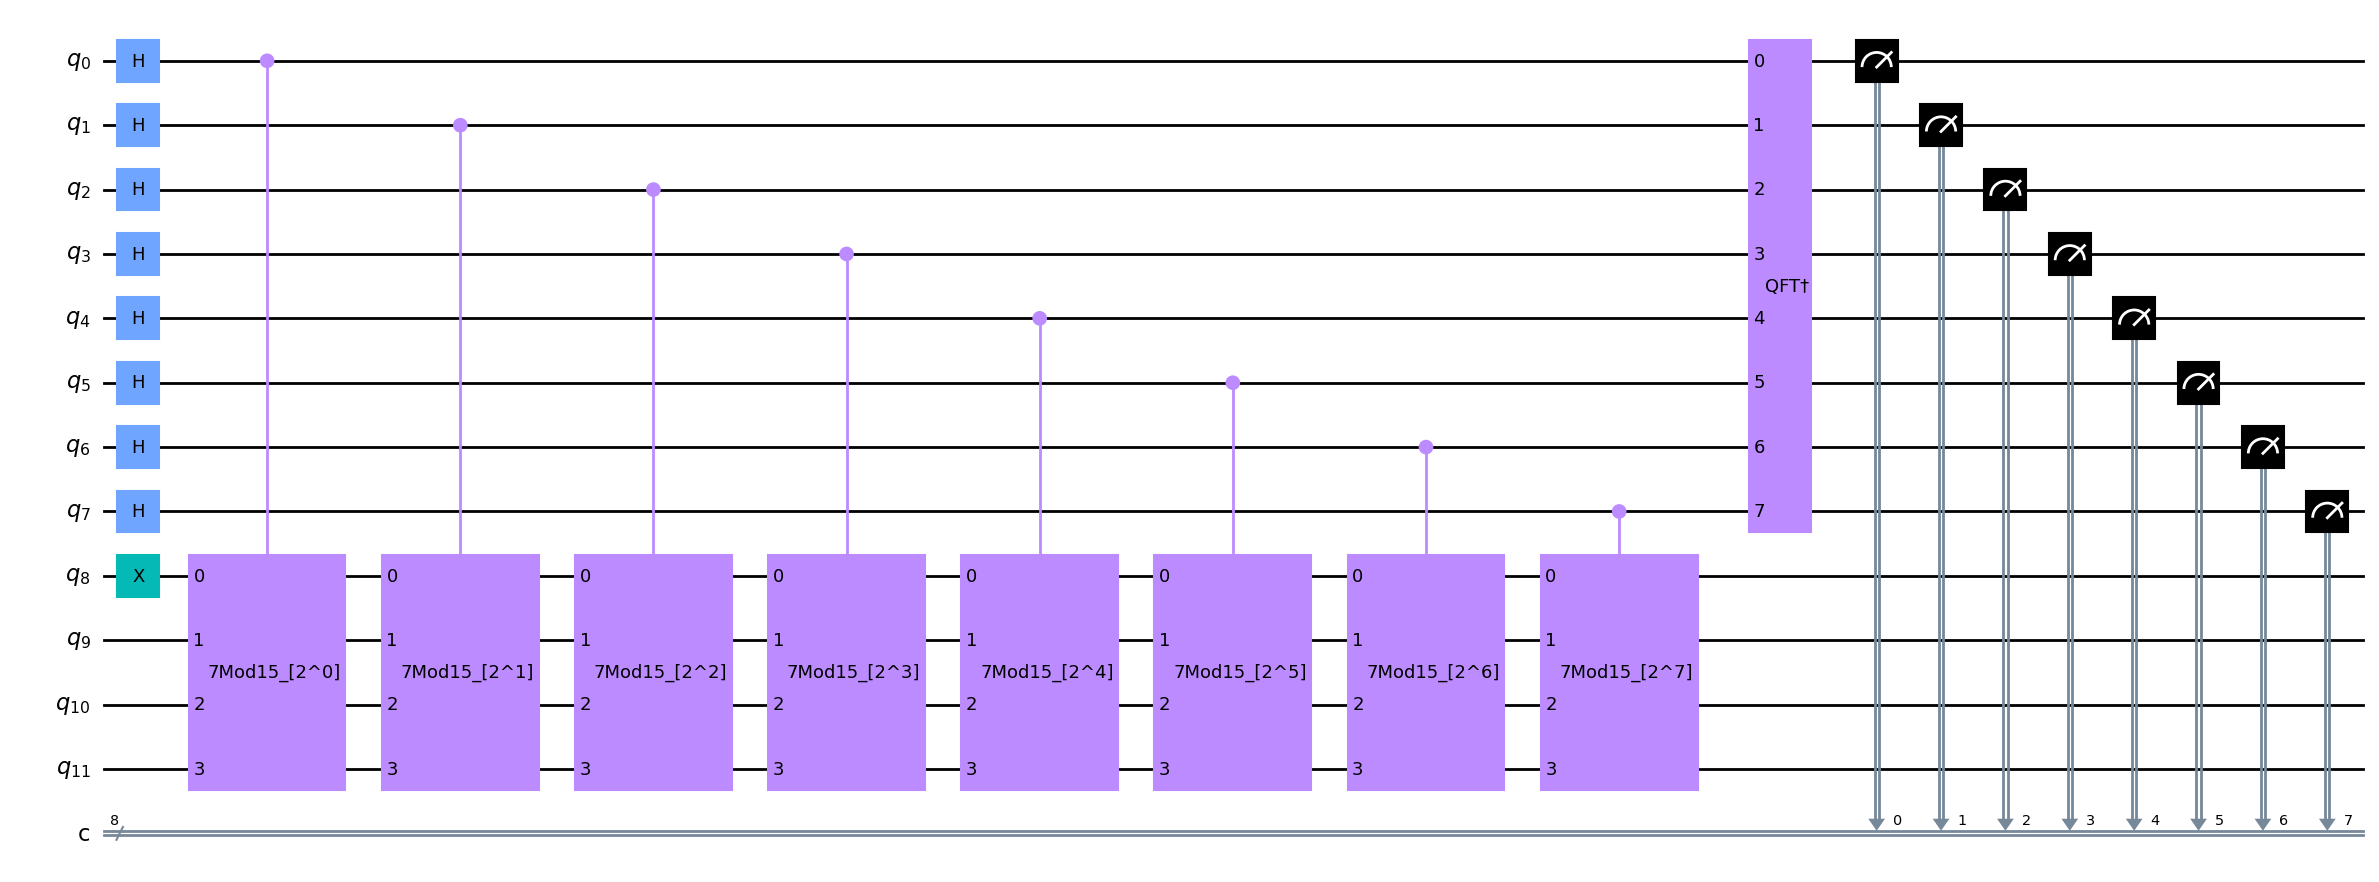

In [58]:
### your code goes here

phase_register = 8
u_register = 4

shor_qpe = QuantumCircuit(phase_register + u_register, phase_register) #Create the QuantumCircuit needed to run with 8 phase register qubits

for i in range(phase_register):
    shor_qpe.h(i)
    
shor_qpe.x(8)
    
for i in range(phase_register):
    ph = cU_multi(i)
    shor_qpe.append(ph,[i] + [j+phase_register for j in range(u_register)])
    
shor_qpe.append(qft_dagger_1(phase_register),range(phase_register))
    
for i in range(phase_register):
    shor_qpe.measure(i,i)
    
shor_qpe.draw("mpl", fold=-1)

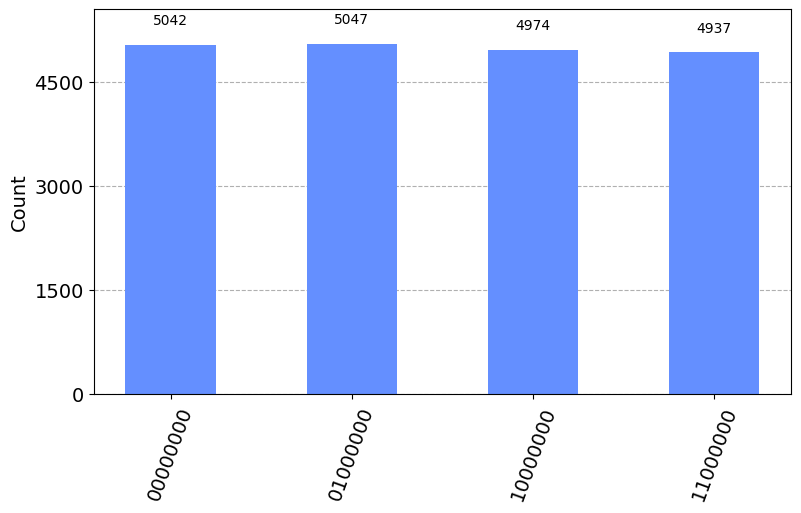

In [52]:
## Run this cell to simulate 'shor_qpe' and to plot the histogram of the results
sim = Aer.get_backend('aer_simulator')
shots = 20000
shor_qpe_counts = execute(shor_qpe, sim, shots=shots).result().get_counts()
plot_histogram(shor_qpe_counts, figsize=(9,5))

Possiamo ora trovare $s$ e $r$ usando l'algoritmo delle funzioni continue. Fortunamente, Python ha una funzione built-in per questo scopo: usando dunque la funzione `Fraction` possiamo stimare $s$ ed $r$ per ognuno dei risultati appena ottenuti.

Per maggiore definizione, sfruttando le ipotesi che abbiamo, limitiamo il denominatore a $15$.

In [53]:
# example off topic
from fractions import Fraction

print(Fraction(0.765), '\n')
print(Fraction(0.765).limit_denominator(15))

6890507429876859/9007199254740992 

10/13


In [54]:
measured_phases = []

for output in shor_qpe_counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**phase_register)  # Find corresponding eigenvalue
    measured_phases.append(phase)

print(measured_phases)

# create a list of Fraction objects for each measurement outcome
shor_qpe_fractions = []

for phase in measured_phases:
    ph_frac = Fraction(phase).limit_denominator(15)
    shor_qpe_fractions.append(ph_frac)
    
print(shor_qpe_fractions)

[0.25, 0.0, 0.5, 0.75]
[Fraction(1, 4), Fraction(0, 1), Fraction(1, 2), Fraction(3, 4)]


### Step 4: uniamo i pezzi!

Proviamo ora a mettere insieme tutti gli step precedenti per fattorizzare $N=15$, usando sempre $a=7$.

Ricordate che la fase che misuriamo è $s/r$, dove $s$ è un intero aleatorio tra $0$ e $r-1$ tale che
$$
    a^r\text{mod}N = 1
$$

Una volta ottenuto $r$, possiamo trovare un fattore di $N$ sfruttando il seguente fatto
$$
    \left(a^r-1\right)\text{mod} N = 0
$$
che implica che $N$ sia divisibile per $a^r-1$. Se $r$ è pari, possiamo anche scrivere
$$
    a^r-1 = \left(a^{r/2}+1\right)\left(a^{r/2}-1\right).
$$

**Ex.7 - Definite una funzione per l'algoritmo di Shor**

Definite una funzione chiamata `shor_qpe` che prende in input il numero $k$ di qubit per contare e compone, esegue e processa l'algoritmo di Shor per indovinare i fattori.
Usate uno stato di input $|y\rangle{}=|1\rangle{}$ per la stima della fase.

(*Nota: la funzione `cU_multi()` esegue$|ay\ \text{mod}\ 15\rangle{}$ solo per $a=7$*)

In [55]:
def shor_qpe(k):

    a = 7
    
    #Step 1. Begin a while loop until a nontrivial guess is found
    ### Your code goes here ###
    
    phase_register = k
    u_register = 4
    
    flag = 0
    while flag == 0:
        
        #Step 2a. Construct a QPE circuit with m phase count qubits
        #  to guess the phase phi = s/r using the function cU_multi()
        ### Your code goes here ###
        shor_qpe = QuantumCircuit(phase_register + u_register, phase_register) #Create the QuantumCircuit needed to run with 8 phase register qubits

        for i in range(phase_register):
            shor_qpe.h(i)

        shor_qpe.x(8)

        for i in range(phase_register):
            ph = cU_multi(i)
            shor_qpe.append(ph,[i] + [j+phase_register for j in range(u_register)])

        shor_qpe.append(qft_dagger_1(phase_register),range(phase_register))

        for i in range(phase_register):
            shor_qpe.measure(i,i)

        #Step 2b. Run the QPE circuit with a single shot, record the results
        # and convert the estimated phase bitstring to decimal
        ### Your code goes here ###
        aer_sim = Aer.get_backend('aer_simulator')
        output = aer_sim.run(transpile(shor_qpe, aer_sim), shots=1, memory=True)
        readings = output.result().get_memory()
        print("Register Reading: " + readings[0])
        
        phase = int(readings[0],2)/(2**phase_register)
        print(f"Corresponding Phase: {phase}")


        #Step 3. Use the Fraction object to find the guess for r
        ### Your code goes here ###
        frac = Fraction(phase).limit_denominator(15)
        s, r = frac.numerator, frac.denominator
        print("r", r)
        
        #Step 4. Now that r has been found, use the builtin greatest common deonominator
        # function to determine the guesses for a factor of N
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]

        #Step 5. For each guess in guesses, check if at least one is a non-trivial factor
        # i.e.  (guess != 1 or N) and (N % guess == 0)
        ### Your code goes here ###
        for guess in guesses:
            if guess not in [1,N] and (N % guess == 0): 
                print("found a non-trivial factor:", guess)
                flag = 1
    
    return guesses

In [56]:
shor_qpe(8)

Register Reading: 10000000
Corresponding Phase: 0.5
r 2
found a non-trivial factor: 3


[3, 1]